In [1]:
import numpy as np
from numpy.linalg import norm
import math
from urllib.request import urlopen
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from urllib.request import urlopen
import random

import urllib
import scipy.optimize
import random
from collections import defaultdict # Dictionaries with default values
import nltk
from nltk.util import ngrams
import string
from nltk.stem.porter import *
import ast
from nltk.corpus import stopwords

import gzip
from collections import defaultdict

# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [2]:
# Parse each json object
def read_JSON(path):
    for l in gzip.open(path, 'r'):
        yield json.loads(l)

## 1. Dataset Exploratory Analysis

#### Contents:
- 1a. Feature Categories
- 1b. Plot Age vs Rating
- 1c. Plot Rating vs Fit Counts
- 1d. Category vs Rating Counts
- 1e. Average Rating Per Category
- 1f. Rating Density in Training Dateset
- 1g. Rented for vs Rating Counts
- 1h. Average Rating Per Rented for
- 1i. Frequent Words Per Rating

Dataset: https://cseweb.ucsd.edu/~jmcauley/datasets.html#clothing_fit (Rent The Runway)

In [3]:
# Load data
data = []
for d in read_JSON('renttherunway_final_data.json.gz'):
    data.append(d)

# Filter data without a rating
for d in data:
    if not d['rating']:
        data.remove(d)

###  Basic Statistics and Properties

In [4]:
# Size of dataset
print("Size of original data set =", len(data), "samples")

# Number of features
print("Number of features =", len(data[0]), "features")

Size of original data set = 192462 samples
Number of features = 15 features


In [5]:
# Example sample
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [6]:
# Split training and test data
random.shuffle(data)
training_data = data[:150000]
test_data = data[150000:]

len(test_data)

42462

### 1a. Feature Categories

* Categorical Features: fit, user_id, bust_size, item_id, rented_for, category, body_type, review_date

* Numerical Features: weight, size, height, age

* Ordinal Features: rating, review_text, review_summary

###  Feature Exploration

In [7]:
# For categorical features determine options
fit_options = set()
rental_reasons = set()
body_types = set()
clothing_categories = set()

for d in training_data:
    fit_options.add(d['fit'])
    if 'rented for' in d:
        rental_reasons.add(d['rented for'])
    if 'body type' in d:
        body_types.add(d['body type'])
    clothing_categories.add(d['category'])

In [8]:
print("Fit Options: ", ', '.join(fit_options), "\n")
print("Rental Reasons: ", ', '.join(rental_reasons), "\n")
print("Body Types: ", ', '.join(body_types), "\n")
print("Clothing Categories: ", ', '.join(clothing_categories), "\n")

Fit Options:  large, small, fit 

Rental Reasons:  formal affair, other, vacation, party, date, everyday, party: cocktail, work, wedding 

Body Types:  athletic, pear, straight & narrow, full bust, hourglass, apple, petite 

Clothing Categories:  overcoat, bomber, jogger, pant, skirts, hoodie, sweatpants, skirt, tight, mini, frock, kaftan, duster, sweatshirt, overalls, vest, poncho, print, jacket, parka, blouse, down, dress, shirt, kimono, crewneck, top, trousers, leggings, romper, coat, culottes, midi, shirtdress, t-shirt, henley, tee, trench, gown, maxi, sheath, combo, skort, knit, trouser, turtleneck, blazer, pullover, tank, tunic, suit, shift, pants, peacoat, cami, blouson, sweater, ballgown, legging, sweatershirt, culotte, caftan, cape, for, cardigan, jumpsuit, jeans 



In [9]:
# Determine # entries without 'rented for'
missing_rent_reason_count = 0
missing_body_type_count = 0
missing_age_count = 0
for d in training_data:
    if 'rented for' not in d:
        missing_rent_reason_count += 1
    if 'body type' not in d:
        missing_body_type_count += 1
    if 'age' not in d:
        missing_age_count += 1

print("Entries missing rental reason:", missing_rent_reason_count, "/", len(training_data))
print("Entries missing body type:", missing_body_type_count, "/", len(training_data))
print("Entries missing age:", missing_age_count, "/", len(training_data))

Entries missing rental reason: 9 / 150000
Entries missing body type: 11397 / 150000
Entries missing age: 737 / 150000


#### 1b. Plot Age vs Rating

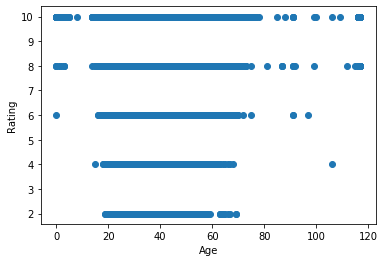

In [10]:
age_vs_rating = np.zeros((len(training_data) - missing_age_count, 2))

i = 0
for d in training_data:
    if 'age' in d:
        age_vs_rating[i][0] = d['age']
        age_vs_rating[i][1] = d['rating']
        i+=1
        
plt.scatter(age_vs_rating[:,0], age_vs_rating[:,1])
plt.xlabel('Age')
plt.ylabel('Rating')
plt.show()

#### Analysis of Age vs Rating
Age versus Rating graph shows age alone is not a strong indicator of rating. Note that individuals of extreme ages (<20 and >80) tend to give higher ratings

#### 1c. Plot Rating vs Fit [Counts]

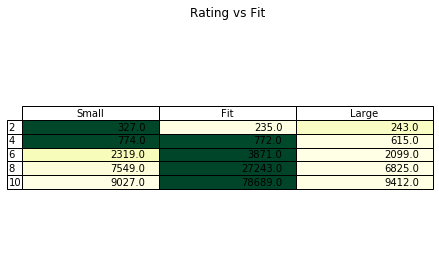

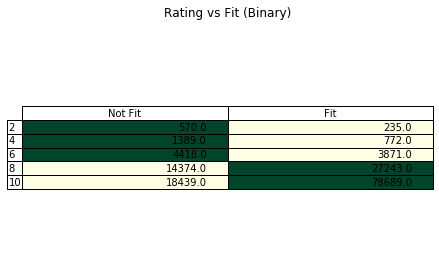

In [11]:
# Plot Rating vs Fit
fit_vs_rating_counts = np.zeros((5, 3))
fit_vs_rating_counts_binary = np.zeros((5, 2))

fitDict = {
  "small": 0,
  "fit": 1,
  "large": 2,
}

fitDict_binary = {
  "small": 0,
  "fit": 1,
  "large": 0,
}

ratingDict = {
    '2': 0,
    '4': 1,
    '6': 2,
    '8': 3,
    '10': 4,
}


for d in training_data:
    fit_vs_rating_counts[ratingDict[d['rating']]][fitDict[d['fit']]]+=1
    fit_vs_rating_counts_binary[ratingDict[d['rating']]][fitDict_binary[d['fit']]]+=1
    

idx = pd.Index(np.arange(2,11, 2))
df = pd.DataFrame(fit_vs_rating_counts, index=idx, columns=['Small', 'Fit', 'Large'])
vals = np.around(df.values,2)

colours = np.zeros((5,3,4))
for i in range(0, 5):
    norm = plt.Normalize(vals[i,:].min()-1, vals[i,:].max()+1)
    colours[i,:] = plt.cm.YlGn(norm(vals[i,:]))

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.set_title('Rating vs Fit')
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellColours=colours)
fig.tight_layout()
plt.show()

idx = pd.Index(np.arange(2,11, 2))
df = pd.DataFrame(fit_vs_rating_counts_binary, index=idx, columns=['Not Fit', 'Fit'])
vals = np.around(df.values,2)

colours = np.zeros((5,2,4))
for i in range(0, 5):
    norm = plt.Normalize(vals[i,:].min()-1, vals[i,:].max()+1)
    colours[i,:] = plt.cm.YlGn(norm(vals[i,:]))

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.set_title('Rating vs Fit (Binary)')
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellColours=colours)
fig.tight_layout()
plt.show()


#### Analysis of Rating vs Fit
From our test data we can identify that reviews that classify the clothing as 'Fit' are more likely to rate an 8 or 10. Similarly, any review classifying the clothing as not 'Fit' are more likely to rate 2, 4, 6 in that same review.

#### 1d. Category vs Rating Counts

In [12]:
# Plot Rating vs Fit
category_list = list(clothing_categories)
category_vs_rating_counts = np.zeros((5, len(category_list)))
category_map = {k: v for v, k in enumerate(category_list)}

ratingDict = {
    '2': 0,
    '4': 1,
    '6': 2,
    '8': 3,
    '10': 4,
}


for d in training_data:
    category_vs_rating_counts[ratingDict[d['rating']]][category_map[d['category']]]+=1

idx = pd.Index(np.arange(2,11, 2))
df = pd.DataFrame(category_vs_rating_counts, index=idx, columns=category_list)
print(df)

    overcoat  bomber  jogger  pant  skirts  hoodie  sweatpants  skirt  tight  \
2        0.0     0.0     0.0   0.0     0.0     0.0         0.0    4.0    0.0   
4        0.0     1.0     0.0   1.0     0.0     0.0         0.0   21.0    1.0   
6        0.0     5.0     0.0  10.0     0.0     2.0         0.0  108.0    4.0   
8        0.0    24.0     4.0  16.0     1.0     3.0         0.0  333.0    1.0   
10       2.0    59.0     0.0  50.0     2.0     7.0         2.0  718.0    3.0   

     mini  ...  ballgown  legging  sweatershirt  culotte  caftan  cape  for  \
2    21.0  ...       0.0      0.0           0.0      0.0     0.0   0.0  0.0   
4    29.0  ...       0.0      0.0           0.0      4.0     0.0   2.0  0.0   
6   115.0  ...       0.0      2.0           1.0      2.0     1.0   4.0  0.0   
8   497.0  ...       1.0      8.0           1.0     23.0     0.0  15.0  1.0   
10  718.0  ...      12.0     55.0           2.0     25.0     2.0  50.0  6.0   

    cardigan  jumpsuit  jeans  
2        1.0

#### 1e. Average Rating Per Category

In [13]:
average_per_category = np.zeros((1, len(category_list)))

i = 0
for category in category_vs_rating_counts.T:
    total_count = sum(category)
    weighted_count = (2 * category[0]) + (4 * category[1]) + (6 * category[2]) + (8 * category[3]) + (10 * category[4])
    average_per_category[0][i] = weighted_count / total_count
    i+=1
    
idx = pd.Index(np.arange(2,3, 2))
df = pd.DataFrame(average_per_category, columns=category_list)
print(df)

   overcoat    bomber  jogger      pant    skirts    hoodie  sweatpants  \
0      10.0  9.168539     8.0  8.987013  9.333333  8.833333        10.0   

      skirt     tight      mini  ...  ballgown   legging  sweatershirt  \
0  8.939189  7.333333  8.698551  ...  9.846154  9.630769           8.5   

    culotte    caftan      cape       for  cardigan  jumpsuit  jeans  
0  8.555556  8.666667  9.183099  9.714286  8.971429  9.013848    6.8  

[1 rows x 67 columns]


#### 1f. Rating Density In Training Dataset

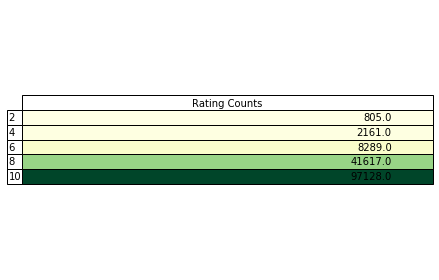

In [14]:
rating_counts = np.zeros((5, 1))

i = 0
for row in fit_vs_rating_counts_binary:
    rating_counts[i][0] = sum(row)
    i+=1
    
idx = pd.Index(np.arange(2,11, 2))
df = pd.DataFrame(rating_counts, index=idx, columns=['Rating Counts'])
vals = np.around(df.values,2)
norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.YlGn(norm(vals))

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellColours=colours)
fig.tight_layout()
plt.show()


#### 1g. Rented for vs Rating Counts

In [15]:
# Plot Rented For vs Rating Counts
rentedFor_list = list(rental_reasons)
rentedFor_vs_rating_counts = np.zeros((5, len(rentedFor_list)+1))
rentedFor_map = {k: v for v, k in enumerate(rentedFor_list)}

ratingDict = {
    '2': 0,
    '4': 1,
    '6': 2,
    '8': 3,
    '10': 4,
}


for d in training_data:
    if 'rented for' not in d:
        rentedFor_vs_rating_counts[ratingDict[d['rating']]][len(rentedFor_list)]+=1
    else:
        rentedFor_vs_rating_counts[ratingDict[d['rating']]][rentedFor_map[d['rented for']]]+=1

idx = pd.Index(np.arange(2,11, 2))
df = pd.DataFrame(rentedFor_vs_rating_counts, index=idx, columns=rentedFor_list + ['Null'])
print(df)

    formal affair   other  vacation    party    date  everyday  \
2           170.0    66.0      20.0    172.0    31.0     102.0   
4           373.0   155.0      64.0    458.0    99.0     327.0   
6          1297.0   664.0     229.0   1671.0   436.0    1180.0   
8          8080.0  3184.0     865.0   7788.0  1691.0    3852.0   
10        21693.0  7867.0    1991.0  17662.0  3475.0    7601.0   

    party: cocktail    work  wedding  Null  
2               0.0    69.0    175.0   0.0  
4               0.0   252.0    433.0   0.0  
6               0.0   949.0   1863.0   0.0  
8               1.0  3720.0  12433.0   3.0  
10              0.0  6676.0  30157.0   6.0  


#### 1h. Average Rating Per Rented for

In [16]:
average_per_event = np.zeros((1, len(rentedFor_list)+1))

i = 0
for event in rentedFor_vs_rating_counts.T:
    total_count = sum(event)
    weighted_count = (2 * event[0]) + (4 * event[1]) + (6 * event[2]) + (8 * event[3]) + (10 * event[4])
    average_per_event[0][i] = weighted_count / total_count
    i+=1
    
idx = pd.Index(np.arange(2,3, 2))
df = pd.DataFrame(average_per_event, columns=rentedFor_list + ['Null'])
print(df)

   formal affair     other  vacation     party      date  everyday  \
0       9.210894  9.121816  8.993373  9.049259  8.958828  8.836166   

   party: cocktail      work  wedding      Null  
0              8.0  8.859935  9.19407  9.333333  


#### 1i. Frequent Words Per Rating

In [22]:
punct = string.punctuation

r2_word_count = defaultdict(int)
r4_word_count = defaultdict(int)
r6_word_count = defaultdict(int)
r8_word_count = defaultdict(int)
r10_word_count = defaultdict(int)

rating_count = defaultdict(int)
for d in data:
    t = d['review_text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # Non-punct characters
    t = ''.join(t) # Convert back to string
    words = t.strip().split() # Tokenizes
    
    rating_count[d['rating']] += 1
    for w in words:
        if w not in stop_words:
            if d['rating'] == '2':
                r2_word_count[w] += 1
            elif d['rating'] == '4':
                r4_word_count[w] += 1
            elif d['rating'] == '6':
                r6_word_count[w] += 1
            elif d['rating'] == '8':
                r8_word_count[w] += 1
            elif d['rating'] == '10':
                r10_word_count[w] += 1

def top_words(word_count):
    counts = [(word_count[w], w) for w in word_count]
    counts.sort()
    counts.reverse()
    return [w[1] for w in counts[:30]]

print("Most frequent words per rating")
word_counts = [(2, r2_word_count), (4, r4_word_count), (6, r6_word_count), (8, r8_word_count), (10, r10_word_count)]
for rating, count in word_counts:
    print(rating, ":", top_words(count), "\n")

rating_count = [(rating_count[w], w) for w in rating_count]
rating_count.sort()
rating_count.reverse()
print("Most common rating: " + rating_count[0][1])

Most frequent words per rating
2 : ['dress', 'wear', 'fit', 'size', 'would', 'like', 'didnt', 'even', 'small', 'way', 'look', 'short', 'really', 'big', 'im', 'looked', 'wearing', 'tight', 'long', 'made', 'back', 'large', 'could', 'top', 'material', 'fabric', 'also', 'chest', 'couldnt', 'ordered'] 

4 : ['dress', 'fit', 'wear', 'size', 'would', 'didnt', 'like', 'really', 'small', 'look', 'top', 'wearing', 'short', 'also', 'tight', 'way', 'fabric', 'im', 'back', 'long', 'even', 'big', 'looked', 'waist', 'large', 'made', 'material', 'could', 'pretty', 'great'] 

6 : ['dress', 'fit', 'would', 'size', 'wear', 'didnt', 'little', 'like', 'really', 'top', 'great', 'bit', 'look', 'small', 'short', 'tight', 'also', 'im', 'fabric', 'long', 'wearing', 'waist', 'color', 'pretty', 'back', 'wore', 'beautiful', 'work', 'made', 'big'] 

8 : ['dress', 'fit', 'size', 'would', 'little', 'wear', 'great', 'wore', 'bit', 'comfortable', 'loved', 'compliments', 'perfect', 'really', 'like', 'im', 'didnt', 'long

## 2. Predictive Task

### About

Our predictive task is predicting a user's rating on a review of their clothing fit on some given features. 

### Baseline Models

One naive baseline predictive model we can use is simply determining if the customer considered the clothing item as "fit", which means the item was neither "small" nor "large". This is a good sign the the customer was satisfied, so we simply guess the rating to be "10". Otherwise we guess a random lesser rating from all other possible ratings in the training data. To get these other ratings, we iterated through the training data, and put all the possible ratings in a set.

Another naive baseline we can do is selectively find the most common words that are not stop-words used in each rating category. For example, in a "10" words that appear may be "perfect" or "great". We can manually select qualitative words for each category, and our predictor would simply predict that rating if those words appear in a review. We found these words by finding the top 30 most frequent non-stop-words for each rating category in the training data. For reviews that have overlapping words in multiple rating categories, the higher rating category would take precedence. The words were founding by creating dictionaries of word counts for each rating.


#### Baseline 1: Predict a rating of 10 if the fit = 'fit', otherwise randomly predict a rating in the range of all other rating in the data set

In [17]:
# Find ratings that aren't 10
other_ratings = set()
for d in data:
    if d['rating'] != '10':
        other_ratings.add(d['rating'])
print("Set of other ratings:", other_ratings)

def baseline1(data, y):
    predictions = []
    for d in data:
        if d['fit'] == 'fit':
            predictions.append('10')
        else:
            predictions.append(random.choice(list(other_ratings)))
    return predictions

y_test = [d['rating'] for d in test_data]
predictions = baseline1(test_data, y_test)
correct = [y_test[i] == predictions[i] for i in range(len(y_test))]
print("Accuracy =", sum(correct) / len(y_test))

Set of other ratings: {'4', '2', '6', '8'}
Accuracy = 0.5548254910272714


#### Baseline 2: Predict based on specific words that appear in the review

In [19]:
def baseline2(data, y):
    predictions = []
    for d in data:
        # If no review, just choose most common in training set
        if not d['review_text']: # if "review_text" not in d
            predictions.append('10')
            continue
        t = d['review_text']
        t = t.lower() # lowercase string
        t = [c for c in t if not (c in punct)] # Non-punct characters
        t = ''.join(t) # Convert back to string
        words = t.strip().split() # Tokenizes
        if "perfect" in words:
            predictions.append(str(rating_count[0][1]))
        elif "great" in words:
            predictions.append('8')
        elif "little" in words:
            predictions.append('6')
        elif "didnt" in words:
            predictions.append('4')
        elif "couldnt" in words:
            predictions.append('2')
        else:
            predictions.append(str(rating_count[0][1])) # Most common
    return predictions
            
y_test = [d['rating'] for d in test_data]
predictions = baseline2(test_data, y_test)
correct = [y_test[i] == predictions[i] for i in range(len(y_test))]
print("Accuracy =", sum(correct) / len(y_test))

Accuracy = 0.4967029343883943


### Logistic Regression

For three of our primary predictors, we decided to train logistic regressors with other features ('weight', 'review_text', 'rented for')

Our first logistic regression model simply looks at review lengths to determine the patterns in the lengths for different review ratings. Why this model is decent is because of the noticeable differences in review lengths for a particular rating. How we created this model is traversing the 'review_text' of each sample and transforming into the length of the value. We then created a feature vector containing all those value and passed it into the logistic regressor.

Our second and third logistic regression models are quite similar. We create a bag of words with one hot encoding of non-stop words and combine that with one hot encoding of ('review_text' for LR 2, 'review_summary' for LR 3) and other features 'fit' and 'rented' for to make one feature vector to fit into our regressor. This allowed our model to become less prone to underfitting as it has more data to make a better prediction. Similarly to the first logistic regression model, we created a set of all possible values to one hot encode for each feature and then when traversing each sample in the training data, we created the corresponding one-hot encoding vector based on what values the sample had for the featuers we used. We then passed those into the logistic regressor to fit and make predictions.

The bag of words was creating by creating word dictionary keeping track of all the words in the training data and its word counts. For 'fit' and 'rented for', we created sets to figure out the number of unique values so we know the one hot encoding length.

Why we decided Logistic Regression to be a good method for this particular task is the ability to make predictions categorically which we need and it works for multi-class predictions. 

#### Primary LR 1: Try logistic regressor that just takes into account the length of a review

In [20]:
def length_feature(datum):
    return [1, len(datum['review_text'])]

X = [length_feature(d) for d in training_data]    
y = [d['rating'] for d in training_data]
model = linear_model.LogisticRegression(C=1, solver='lbfgs', multi_class='auto', max_iter=10000)
model.fit(X, y)

X_test = [length_feature(d) for d in test_data] 
y_test = [d['rating'] for d in test_data]
predictions = model.predict(X_test)
correct = [y_test[i] == predictions[i] for i in range(len(y_test))]
print("Accuracy =", sum(correct) / len(y_test))

Accuracy = 0.6454476944091188


#### Primary LR 2: Try logistic regressor with features ['rented for', 'review_text', 'fit']

In [24]:
word_count = defaultdict(int)
total_words = 0

rented_for_set = set()
fit_set = set()

for d in training_data:
    if 'rented for' in d:
        rented_for_set.add(d['rented for'])
    if 'fit' in d:
        fit_set.add(d['fit'])
    t = d['review_text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if w not in stop_words:
            total_words += 1
            word_count[w] += 1

rented_for_ID = dict(zip(list(rented_for_set), range(len(rented_for_set))))
fit_ID = dict(zip(list(fit_set), range(len(fit_set))))

print(rented_for_ID)
print()
print(fit_ID)

{'formal affair': 0, 'other': 1, 'vacation': 2, 'party': 3, 'date': 4, 'everyday': 5, 'party: cocktail': 6, 'work': 7, 'wedding': 8}

{'large': 0, 'small': 1, 'fit': 2}


In [25]:
counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()
counts[:10]
print(len(counts))

words = [w[1] for w in counts[:1500]]
word_ID = dict(zip(words, range(len(words))))
word_set = set(words)
print(len(word_set))

def dictionary_feature(datum):
    feat = [0]*len(word_set)
    t = datum['review_text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if not (w in word_set): continue
        feat[word_ID[w]] += 1
    # Get One-hot-encoding for 'rented for' and 'fit'
    rented_for_OHE = [0] * len(rented_for_ID)
    fit_OHE = [0] * len(fit_ID)
    if 'rented for' in datum and datum['rented for'] in rented_for_ID:
        rented_for_OHE[rented_for_ID[datum['rented for']]] = 1
    if 'fit' in datum and datum['fit'] in fit_ID:
        fit_OHE[fit_ID[datum['fit']]] = 1
    feat += rented_for_OHE + fit_OHE
    feat.append(1)
    return feat

42658
1500


In [26]:
X_train = [dictionary_feature(d) for d in training_data]
y_train = [d['rating'] for d in training_data]

model = linear_model.LogisticRegression(C=1, solver='lbfgs', multi_class='auto', max_iter=10000)
model.fit(X_train, y_train)

X_test = [dictionary_feature(d) for d in test_data] 
y_test = [d['rating'] for d in test_data]
predictions = model.predict(X_test)
print(sum(predictions == y_test) / len(y_test))

0.7004615891856248


#### Primary LR 3: Try logistic regressor with features ['rented for', 'review_text', 'fit']

In [ ]:
word_count = defaultdict(int)
total_words = 0

rented_for_set = set()
fit_set = set()

for d in training_data:
    if 'rented for' in d:
        rented_for_set.add(d['rented for'])
    if 'fit' in d:
        fit_set.add(d['fit'])
    t = d['review_summary']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if w not in stop_words:
            total_words += 1
            word_count[w] += 1

rented_for_ID = dict(zip(list(rented_for_set), range(len(rented_for_set))))
fit_ID = dict(zip(list(fit_set), range(len(fit_set))))

print(rented_for_ID)
print()
print(fit_ID)

In [ ]:
counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()
counts[:10]
print(len(counts))

words = [w[1] for w in counts[:1500]]
word_id = dict(zip(words, range(len(words))))
word_set = set(words)
print(len(word_set))

def dictionary_summary_feature(datum):
    feat = [0]*len(word_set)
    t = datum['review_text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if not (w in word_set): continue
        feat[word_id[w]] += 1
    # Get One-hot-encoding for 'rented for' and 'fit'
    rented_for_OHE = [0] * len(rented_for_ID)
    fit_OHE = [0] * len(fit_ID)
    if 'rented for' in datum and datum['rented for'] in rented_for_ID:
        rented_for_OHE[rented_for_ID[datum['rented for']]] = 1
    if 'fit' in datum and datum['fit'] in fit_ID:
        fit_OHE[fit_ID[datum['fit']]] = 1
    feat += rented_for_OHE + fit_OHE
    feat.append(1)
    return feat

In [ ]:
X_train = [dictionary_summary_feature(d) for d in training_data]
y_train = [d['rating'] for d in training_data]

model = linear_model.LogisticRegression(C=1, solver='lbfgs', multi_class='auto', max_iter=10000)
model.fit(X_train, y_train)

X_test = [dictionary_summary_feature(d) for d in test_data] 
y_test = [d['rating'] for d in test_data]
predictions = model.predict(X_test)
print(sum(predictions == y_test) / len(y_test))

### KNN Models

Other primary models we considered is a KNN model. Why we considered using KNN is because we are doing a categorical prediction, clustering is a good strategy that could've helped to group certain points to which ever cluster (rating group) they belong to. Out of all the clustering techniques, KNN is most simple inuitive so we tested our prediction with this model. It is also flexible in changing the number of neighbors which could greatly affect the performance.

Our first KNN model (Primary KNN 1), we only used the length of feature 'review_text'. We went with 11 neighbors after testing multiple different neighbor values and found 11 to give the best accuracy. The review length is found by traversing the entire training data and changing calling the len() function on the review string.

Our second KNN model (Primary KNN 2) uses 'weight', 'review_text' and 'fit'. Similarly to some of our logistic regression models, we used bag of words with one hot encoding for the 'review_text' and found a good dictionary size from testing different sizes. As for 'weight' and 'fit', we also one hot encoded those values and threw them into the KNN classifier.

#### Primary KNN 1: Try KNN that just takes into account the length of the review

In [ ]:
def length_feature(datum):
    return [1, len(datum['review_text'])]

X = [length_feature(d) for d in training_data]    
y = [d['rating'] for d in training_data]
model = KNeighborsClassifier(n_neighbors=11)
model.fit(X, y)

X_test = [length_feature(d) for d in test_data] 
y_test = [d['rating'] for d in test_data]
predictions = model.predict(X_test)
correct = [y_test[i] == predictions[i] for i in range(len(y_test))]
print("Accuracy =", sum(correct) / len(y_test))

#### Primary 2: Try KNN with features ['rented for', 'review_text', 'fit']

**[Failed]**

**KNN required too much memory for such a large dataset.**

```
counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()
counts[:10]
print(len(counts))

words = [w[1] for w in counts[:1400]]
word_ID = dict(zip(words, range(len(words))))
word_set = set(words)
print(len(word_set))

X_train = [dictionary_feature(d) for d in training_data]
y_train = [d['rating'] for d in training_data]

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

X_test = [dictionary_feature(d) for d in test_data] 
y_test = [d['rating'] for d in test_data]
predictions = model.predict(X_test)
print(sum(predictions == y_test) / len(y_test))
```

### Assessing Validity of our Models

How we plan to judge the validity of our models is by creating a train / test split on our original data set. We decided to go with a 80/20 split. We then train our models on the training split and then see how our model performs on the test split in terms of its accuracy.

## 3. Justification for Proposed Model, Optimizations, Issues, Model Alternatives

#### Justification for Model (Primary Model LR 2), Strengths and Weaknesses

Out of all the models we proposed, the model we would choose overall for this task would be our Primary Model 2 which uses Logistic Regression on the features ('rented for', 'fit', 'review_text'). Why we decided to go with this model is first, the label or what we are predicting is a category in itself ('rating') so we knew this was a classification task overall and with what we learned from previous homeworks, Logistic Regression works for multi-class predictions.

For our feature selection, we chose our features by comparing them to the label and checking for possible correlation. After looking through most of the features, we went with 'fit' for one feature as it was a good indicator that when an item was given a a higher rating, the 'fit' was likely 'fit' compared to being marked as 'small' or 'large'. We compared the frequencies of reviews with certain ratings to each value of 'fit'.

Another feature we chose was 'rented for'. The reason we chose this feature is from our intuition that based on the situation you rented something for, the customer could be more picky. For example, if the occassion was a wedding, the customer would want to look really good so the margin for a customer to be unhappy with the item is higher.

The last feature we included was 'review_text'. Why we chose to include the review itself is the importance of what the customer had to say about the item itself. If a user said positive words about the item, a higher rating is likely and vice versa for a low rating. Using the Bag of Words method, we were able to transform the review into a one-hot encoded list that would get passed into our logistic regressor. 

We considered using tf-idf for this model but given the recent discoveries from our previous homework, we had a feeling word counts intead of tf-idf would perform better so we went with that path.

The downsides of this model is mainly the fact that the bag of words feature vector is very decently large so fitting the logistic regressor takes quite some time which cuts into the efficiency. Also, there is potential for under fitting and over fitting, so tuning the parameters closely is a must.

#### Optimizations

The main optimizations we did was first, removing stop words from our dictionary. This allowed us to key more on common words that have more meaning and a bigger impact on the prediction we should be making for some review_text. Another optimization was testing different dictionary sizes to account for under / over fitting.

#### Issues

Some issues we had due to scalability was mainly working with super large amounts of samples. When we run our logistic regressor to fit on the features, it would take a really long time for the process to complete. In regards to overfitting, when creating our bag of words, we had to test multiple sizes of our dictionary to find a good size. If we included too many words, we noticed the accuracy was decreasing on our test set so we knew we had to keep testing different values and find the optimal size for our model.

#### Other Models for Comparison (Strengths and Weaknesses)

###### Baseline Model 1:

For one of our baseline models, we only considered the 'fit' feature and predicted a 10 for the rating if the fit value is 'fit', otherwise we predict a random rating from the set of all possible ratings not 10 from the training data. 

The pros of this model is there is not lots of overhead. It did not require anything complex and made predictions off of one feature. All that was needed was to get the set of all possible rating values and to heck the 'fit' feature for each sample.

The cons of this model is that is quite a trivial predictor. It assumes an item that 'fit' is considered perfect and that the user will give a 10. Also, when the item did not 'fit' (i.e 'small' or 'large'), it was randomized on what the rating should be instead of taking into account the differences between a rating of '4 ' is compared to '6' for example.

###### Baseline Model 2:

This baseline model was based off of a common word for the set of samples corresponding to some rating by looking only at the feature review_text. This model was done by keep track of the counts for each non-stop word for each rating separately. Then, we chose some word from the top 30 words for each rating that were different and used that as a baseline for which rating to predict for some sample. (i.e if "perfect" is in the sentence", predict a 10, if "didn't" is in the sentence, predict a 4).

The pros of this model is it takes into account argueably the most important feature, which is the review. It also makes a good guess for which word is important and does it from one common non-stop words for each rating. There is not much complexity in the model so there is not much overheard to "train" the model.

The cons of this model is it only takes into account one word per category (rating). Therefore, there could be issues with overfitting / underfitting because the model makes the prediction off one specific word per rating. When a sample might contain words that were the deciders for two or more different ratings, the likelihood for an incorrect prediction is higher.

###### Primary LR Model 1

For the first LR primary model (primary meaning models we actually considered), we looked at only the review length. After looking at the average lengths of reviews for different ratings, we noticed there seems to be a distinction among review lengths and the rating, so we made a logistic regressor taking review lengths as the only feature. 

The pros of this model is it uses a feature with a lot of variance that we were able to transform and reduce dimensionality of the review_text in a way that makes the logistic regressor fit the model for predictions much more easier. There was no bag of words or one hot encoding which really increase the run time for regressor to find a good theta.

The cons of this model is first, it only uses one feature to fit a logistic regressor so it could possibly need more data to create a good prediction although review_text seems to be the most important feature. Also, since it performs a transformation on the review_text, there is a loss of information into the value of each word and how important the meaning of the review_text itself is which could lead to a bad prediction.

##### Primary LR Model 2 (Already discussed as model of choice above)

##### Primary LR Model 3

The third LR primary model is very similar to the model we ended up choosing for the task with the difference being that instead of review_text, we use review_summary instead. The reason for this model is that although the review_summary is less descriptive, it is possible the summary can give the model enough information to make a good prediction of the rating. Still performing bag of words and one hot encoding on some dictionary size along with one hot encoding the 'fit' and 'rented for' feature, we were able to create a logistic regressor to perform multi class predictions.

The pros of this model is it uses multiple features to base its prediction on so theres more information into creating a better model, it slightly performs a trade-off of information to reduce the possibility of looking through too many unimportant words while maintaining most of the information from each user's review of an item. 

The cons of this model is the review summary is way less shorter than the review_text, so possible lost of important key words that are only found in the review_text could make this model perform worse than a model that uses the entire review.

##### Primary KNN Model 1

The first Primary KNN Model only used the length of the 'review_text' feature to make its prediction. The motive behind this model was trying a different alternative to logistic regression that still works for categorical predictions through clustering. How the number of neighbors was chosen was by testing different values and keeping what gave us the best performance on the test set.

The pros of this model is that it is simple and easy to do. KNN also ran and fit a model and predicted values fairly quick so this model is very lightweight because it is one dimensional. It also is more flexible in how we can optimize how the model predicts its values by looking a certain amount of neighbors.

The cons of this model is that we are considering one feature here which is the length of the 'review_text'. There is great possibility we are missing on more important features / dimensions that could give us better performance. It also completely ignores the words in the review that could be important. 

##### Primary KNN Model 2

The second Primary KNN Model used similar features to Primary LR Model 2 ('review_text', 'fit', 'rented for'). The reason we chose the same featuers was to allow for a good comparison between logistic regression and KNN. However, unfortunately, the KNN classifier was not able to fit a model to the features. The reasons could be the feature vector is too long for each sample or the dataset was just too large. 

The pros of this model is the semantics of KNN using n number of neighbors to make its prediction which is very flexible and could perform well in certain situations.

The cons of this model is the overheard from the features being used resulting in lots of memory usage and long fit times (possibly never finishing like our experience). 

#### Unsuccessful Attempts

Some attempts we tried along the way was trying to incorporate features such as 'weight', 'age', 'size', and 'category'. Although these features do seem like features that have a lot of weight on the outcome, we found the models to not perform as well as we thought they should have. We also considered using a Ridge regressor, but it produced a continuous output when we needed a categorical output from our labels.

Our Primary KNN Model 2 was also unsuccessful because it never was able to complete the fit() function so we were unable to see the performance of the model. We believe it is a memory issue that made the classifier either just take super long to find a good fit 

## 4. Literature Description

The data was orignally scraped by Rishabh Misra, Mengting Wan, and Julian McAuley, all affiliated with the University of California, San Diego. It was used for a paper titled *Decomposing Fit Semantics for Product Size Recommendation in Metric Spaces* which gave insight in how to tackle the product fit problem for online clothing retailers, to decrease the amount of return rates, which can be expensive. One of the datasets in the paper was our dataset, which were fit reviews obtained from *RentTheRunWay*, which is an online company that rents designer clothing and accessories.

Another dataset used in the paper is from *ModCloth*, which was used in the same way. Together these datasets were used with techniques that include "Learning Fit Semantics" and "Metric Learning". The results were effective, showing high AUC correctness with the predictive models.

Another paper, *SizeNet: Weakly Supervised Learning of Visual Size and Fit in Fashion Images* by Nour Karessli, Romain Guigoures, and Reza Shirvany, tackled this problem with other approaches with both quantitave and qualitative methods "Teacher-Student Learning" and "Statistical Modeling." Instead of data mining, they used more of a computer vision approach that analyzed images to determine how likely an item was to fit with the developed *SizeNet*.

These works are different from our own findings, because our goals are different. While they are trying to model how well a clothing item fits, we are simply guessing how a user would rate how well a clothing item fits from previous purchases/rentals. Interestingly, we had similar results to the UCSD study with respect to accuracy. Other models that would compare better to ours would be our own predictive tasks to determine ratings that we have done from our previous class assignments, such as the ones performed on the beer and steam review datasets, which all performed at around a 70% accuracy like ours, using similar techniques.

## 5. Results and Conclusions

### Citations:

#### Decomposing fit semantics for product size recommendation in metric spaces

Rishabh Misra, Mengting Wan, Julian McAuley

*RecSys, 2018*

http://cseweb.ucsd.edu/~jmcauley/pdfs/recsys18e.pdf

#### SizeNet: Weakly Supervised Learning of Visual Size and Fit in Fashion Images

Nour Karessli, Romain Guigoures, Reza Shirvany

*Zalando SE, 2019*

https://arxiv.org/abs/1905.11784